In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
import datetime
import copy
import time
import wandb
import pickle as pkl
import sys
import math
sys.path.append('../../')
from data.processing import get_data
import models
from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles
from viz.fit import plot_histogram, plot_all_histograms, plot_mean_variance, plot_scatter, plot_kl_divergence, plot_heatmap_distribution_sigmas, plot_all_params, plot_all_losses, plot_all_buckets, plot_cv_in_params, plot_recovery_loss, plot_confidence_interval
import yaml
from data.dataloader import SimulatedDataLoader

In [3]:
def update_hosp_ratios(param_set, data_config, model_config):
    df = pd.read_csv(os.path.join('../../data/data/simulated_data/', data_config['output_file_name']), index_col=0)
    if model_config['end_date']:
        if isinstance(end_date, int):
            if end_date > 0:
                raise ValueError('Please enter a negative value for end_date if entering an integer')
        if isinstance(end_date, datetime.date):
            end_date = df.loc[df['date'].dt.date == end_date].index[0] - len(df) + 1
    else:
        end_date = 0
    train_start_row = df.iloc[len(df) - (model_config['train_period'] + model_config['val_period'] + model_config['test_period']) + end_date]
    if data_config['model'] == 'SEIRHD':
        param_set['E_hosp_ratio'] = train_start_row['E'] / train_start_row['active']
        param_set['I_hosp_ratio'] = train_start_row['I'] / train_start_row['active']
    elif data_config['model'] == 'SEIR_PU':
        param_set['E_hosp_ratio'] = train_start_row['E'] / train_start_row['active']
        param_set['I_hosp_ratio'] = train_start_row['I'] / train_start_row['active']
        param_set['Pu_pop_ratio'] = train_start_row['Pu'] / train_start_row['']
    return param_set

In [4]:
model_config_filename = 'default.yaml'
simulated_config_filename = 'seirhd_fixed.yaml'
with open(os.path.join("../../configs/seir/", model_config_filename)) as configfile:
    model_config = yaml.load(configfile, Loader=yaml.SafeLoader)    
with open(os.path.join("../../configs/simulated_data/", simulated_config_filename)) as configfile:
    simulated_config = yaml.load(configfile, Loader=yaml.SafeLoader)    
actual_params = simulated_config['params']
actual_params = update_hosp_ratios(actual_params, simulated_config, model_config['fitting']['split'])

old dict:
    'losses'
        param names
            perc change
                list of 10 runs
                each element contains a dict {losses: dataframe, best_params: dict}
    'data_config': simulated data config
    'model_config': model config
    'params_to_fix': list

In [19]:
save_dir = '../../misc/predictions/sensitivity/' 
file_names = ['losses_long_range.pickle', 'losses_fixed_tfatal.pickle', 'losses_fixed_fatal_inf.pickle']
tag = ["", "T_fatal", "T_inf"]
param_to_pick = ['T_recov_fatal', 'T_inf', 'T_inc']
df_list = []
for i, file_name in enumerate(file_names):
    with open(os.path.join(save_dir, file_name), 'rb') as handle:
        losses = pkl.load(handle)
    param = param_to_pick[i]
    train_loss, val_loss, param_best_val = [], [], []
    df = {}
    df['fixed_param'] = " ".join(param_to_pick[:i+1])
    for run in losses['losses'][param][0]:
        train_loss.append(np.mean(run['losses']['train']))
        val_loss.append(np.mean(run['losses']['val']))
        param_best_val.append(run['best_params'])

    df['train_mean'] = np.mean(np.array(train_loss))
    df['val_mean'] = np.mean(np.array(val_loss))
    param_dict = pd.DataFrame(param_best_val).describe().loc['mean'].to_dict()
    df.update({i+"_mean":j for i,j in param_dict.items()})

    df['train_std'] = np.std(np.array(train_loss))
    df['val_std'] = np.std(np.array(val_loss))
    param_dict = pd.DataFrame(param_best_val).describe().loc['std'].to_dict()
    df.update({i+"_std":j for i,j in param_dict.items()})
    print (param)
    print (df)
    print ()
    df_list.append(df)

T_recov_fatal
{'fixed_param': 'T_recov_fatal', 'train_mean': 0.8317788891993152, 'val_mean': 2.593557626642989, 'E_hosp_ratio_mean': 1.2890866195877482, 'I_hosp_ratio_mean': 4.150507541015271, 'P_fatal_mean': 0.08219844672511775, 'T_inc_mean': 72.83485266466008, 'T_inf_mean': 38.35433833602246, 'T_recov_mean': 21.15273218405806, 'lockdown_R0_mean': 1.4464392896263167, 'train_std': 0.2777980724555685, 'val_std': 1.576465549648382, 'E_hosp_ratio_std': 1.4937112562008599, 'I_hosp_ratio_std': 0.9270633027542439, 'P_fatal_std': 0.00348753279450146, 'T_inc_std': 17.489299413119156, 'T_inf_std': 10.199569927203243, 'T_recov_std': 0.5350197271513484, 'lockdown_R0_std': 1.9946092342790318}

T_inf
{'fixed_param': 'T_recov_fatal T_inf', 'train_mean': 0.7407175776974999, 'val_mean': 4.390003848791343, 'E_hosp_ratio_mean': 3.4709913206948415, 'I_hosp_ratio_mean': 0.6106349667400581, 'P_fatal_mean': 0.08121919701654749, 'T_inc_mean': 73.70122744012062, 'T_recov_mean': 21.869315235642866, 'lockdown_R

In [20]:
plot_df = pd.DataFrame(df_list)
plot_df['num_fix'] = plot_df['fixed_param'].apply(lambda x: len(x))
plot_df

,fixed_param,train_mean,val_mean,E_hosp_ratio_mean,I_hosp_ratio_mean,P_fatal_mean,T_inc_mean,T_inf_mean,T_recov_mean,lockdown_R0_mean,train_std,val_std,E_hosp_ratio_std,I_hosp_ratio_std,P_fatal_std,T_inc_std,T_inf_std,T_recov_std,lockdown_R0_std,num_fix
0,T_recov_fatal,0.831779,2.593558,1.289087,4.150508,0.082198,72.834853,38.354338,21.152732,1.446439,0.277798,1.576466,1.493711,0.927063,0.003488,17.489299,10.19957,0.535020,1.994609,13
1,T_recov_fatal T_inf,0.740718,4.390004,3.470991,0.610635,0.081219,73.701227,NaN,21.869315,2.916747,0.129554,1.723455,1.427807,0.052704,0.003286,20.522196,NaN,0.821510,1.909459,19
2,T_recov_fatal T_inf T_inc,0.645592,2.148724,0.539347,0.443109,0.082418,NaN,NaN,21.479939,0.710558,0.133531,1.160343,0.221187,0.085682,0.004909,NaN,NaN,0.589012,0.159879,25


In [21]:
actual_params

{'N': 10000000.0,
 'lockdown_R0': 0.8,
 'T_inc': 5.1,
 'T_inf': 3.6,
 'T_recov': 21.5,
 'T_recov_fatal': 25.5,
 'P_fatal': 0.08,
 'E_hosp_ratio': 0.38526592745724486,
 'I_hosp_ratio': 0.5069723736139823}

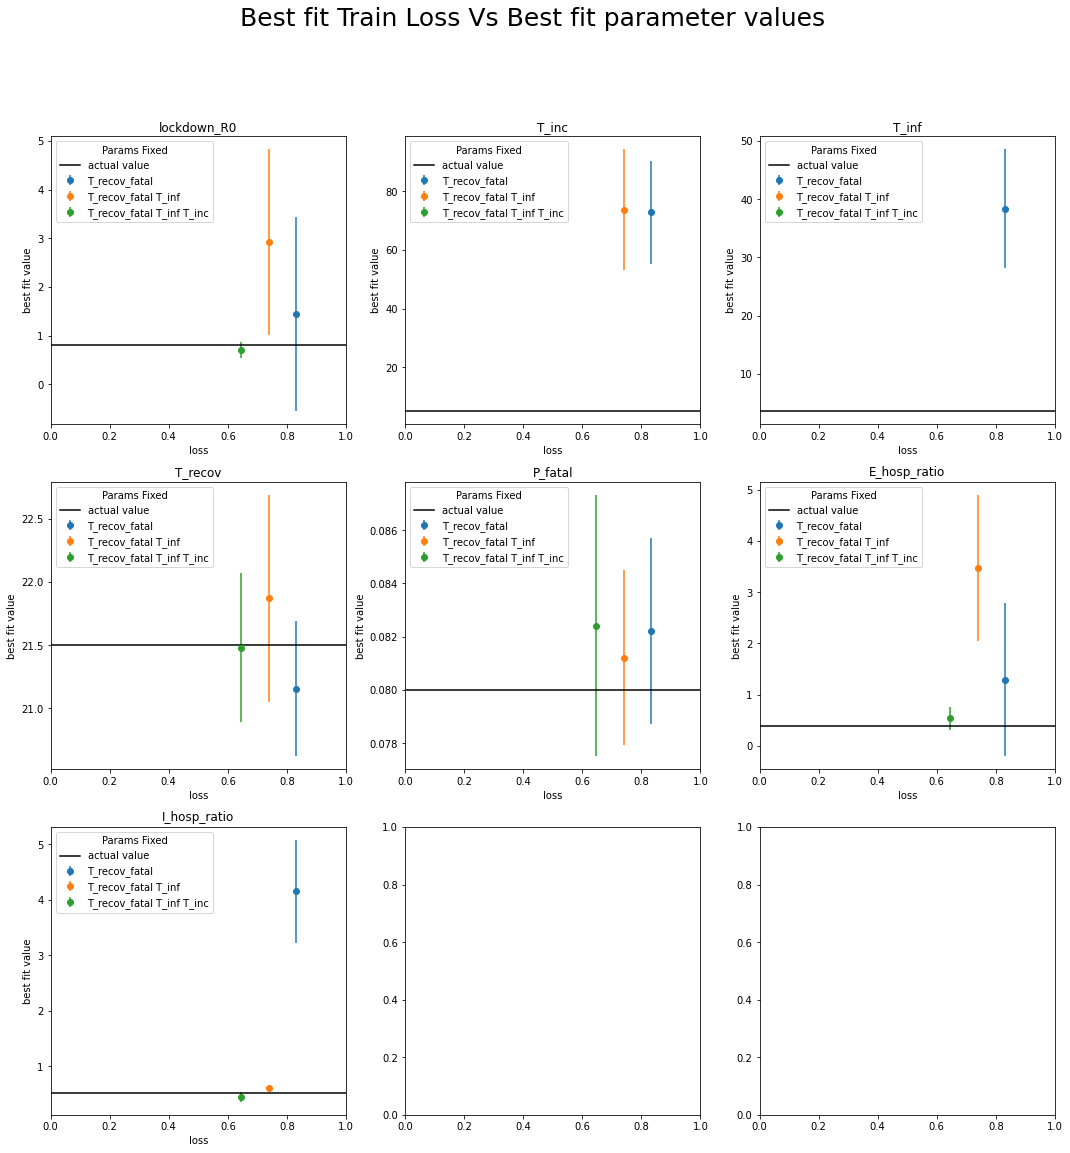

In [51]:
sc = plot_df['fixed_param'].to_list()
n_subplots = len(actual_params) - 2
ncols = 3
nrows = math.ceil(n_subplots/ncols)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, 
                        figsize=(18, 6*nrows))
fig.suptitle('Best fit Train Loss Vs Best fit parameter values ', fontsize=25)
ax_counter = 0
for i, param in enumerate(actual_params):
    if param == 'N' or param == 'T_recov_fatal':
        continue
    ax = axs.flat[ax_counter]
    ax.set_title(param)
    for s in sc:
        curr_df = plot_df[plot_df['fixed_param'] == s]
        ax.errorbar(curr_df['train_mean'], curr_df[param+"_mean"], yerr=curr_df[param+"_std"], fmt="o", label=s) 
    ax.axhline(y=actual_params[param], color='black', label='actual value')
    ax.legend(loc='upper left', title="Params Fixed")
    ax.set_xlim(0,1)
    ax.set_xlabel("loss")
    ax.set_ylabel("best fit value")
    ax_counter += 1

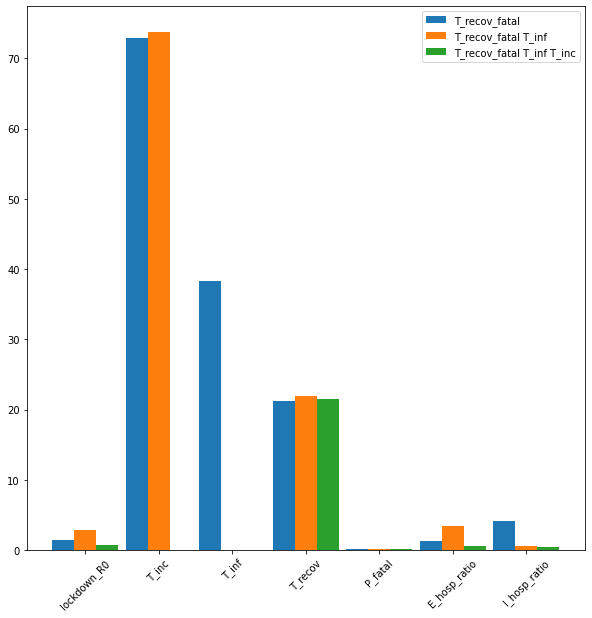

In [117]:
plt.figure(1, figsize=(10,10))
param_list = [i for i in list(actual_params.keys()) if i != 'N' and i != 'T_recov_fatal']
ind = np.arange(len(param_list))
width = 0.3
for i in range(len(plot_df)):
    plt.bar(ind + (i-1)*width, plot_df.loc[i,[j+"_mean" for j in param_list]], width, label=plot_df.loc[i,"fixed_param"])
# plt.twinx()
# for i in range(len(plot_df)):
    # plt.bar(ind + (i-1)*width, plot_df.loc[i,"train_mean"], width, label=plot_df.loc[i,"fixed_param"])
plt.xticks(ind, param_list, rotation=45)
plt.legend()